## Keras Digit Demonstration

In this exercise, we will use a CNN to classify hand-written digits using Keras.

### Imports

In [0]:

import numpy as np
import time
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import LabelBinarizer, minmax_scale

plt.rcParams['figure.figsize'] = (15.0, 3.0)

### Install libraries we will need to visualize our DNN

In [2]:
!pip install pydot
!apt-get install -yq graphviz

    100% |████████████████████████████████| 133kB 8.1MB/s 
  Running setup.py bdist_wheel for pydot ... - done
  Stored in directory: /content/.cache/pip/wheels/6a/a5/14/25541ebcdeaf97a37b6d05c7ff15f5bd20f5e91b99d313e5b4
Successfully built pydot
Reading package lists...
Building dependency tree...
Reading state information...
The following additional packages will be installed:
  fontconfig libcairo2 libcdt5 libcgraph6 libdatrie1 libgd3 libgraphite2-3
  libgvc6 libgvpr2 libharfbuzz0b libjbig0 libltdl7 libpango-1.0-0
  libpangocairo-1.0-0 libpangoft2-1.0-0 libpathplan4 libpixman-1-0
  libthai-data libthai0 libtiff5 libwebp6 libxaw7 libxcb-render0 libxcb-shm0
  libxmu6 libxpm4 libxt6
Suggested packages:
  gsfonts graphviz-doc libgd-tools
The following NEW packages will be installed:
  fontconfig graphviz libcairo2 libcdt5 libcgraph6 libdatrie1 libgd3
  libgraphite2-3 libgvc6 libgvpr2 libharfbuzz0b libjbig0 libltdl7
  libpango-1.0-0 libpangocairo-1.0-0 libpangoft2-1.0-0 libpathplan4
  l

Selecting previously unselected package libcairo2:amd64.
Preparing to unpack .../11-libcairo2_1.14.10-1ubuntu1_amd64.deb ...
Unpacking libcairo2:amd64 (1.14.10-1ubuntu1) ...
Selecting previously unselected package libltdl7:amd64.
Preparing to unpack .../12-libltdl7_2.4.6-2_amd64.deb ...
Unpacking libltdl7:amd64 (2.4.6-2) ...
Selecting previously unselected package libthai-data.
Preparing to unpack .../13-libthai-data_0.1.26-3_all.deb ...
Unpacking libthai-data (0.1.26-3) ...
Selecting previously unselected package libdatrie1:amd64.
Preparing to unpack .../14-libdatrie1_0.2.10-5_amd64.deb ...
Unpacking libdatrie1:amd64 (0.2.10-5) ...
Selecting previously unselected package libthai0:amd64.
Preparing to unpack .../15-libthai0_0.1.26-3_amd64.deb ...
Unpacking libthai0:amd64 (0.1.26-3) ...
Selecting previously unselected package libpango-1.0-0:amd64.
Preparing to unpack .../16-libpango-1.0-0_1.40.12-1_amd64.deb ...
Unpacking libpango-1.0-0:amd64 (1.40.12-1) ...
Selecting previously unselect

### Keras Libraries and Modules

In [3]:
import keras
from keras.datasets import mnist
from keras.models import Sequential, Model, load_model
from keras.layers import Dense, Dropout, Flatten, Input, Lambda, Concatenate
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from keras.callbacks import LearningRateScheduler
from keras import backend as K
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

Using TensorFlow backend.


### Import dataset from Keras

We create a combined dataset with test and training rows.  We will features in `model.fit` to create a validation dataset later in the exercise.

Notice that the digits are 4D tensors.  The first dimension is the "row" or sample image index.  The next to dimensions are the spatial dimensions, x/y.  The last dimension is for color channels.  In this case, we have one color channels since the images are black and white.

In [4]:
(x_train_, y_train_), (x_test_, y_test_) = mnist.load_data()
X = np.vstack([x_train_,x_test_])[...,np.newaxis]
y_ = np.hstack([y_train_,y_test_])
train_ = np.hstack([y_train_*0+1,0*y_test_])
label_coder = LabelBinarizer()

label_coder.fit(y_)

Y = label_coder.transform(y_)
X.shape, Y.shape

11493376/11490434 [==============================] - 3s 0us/step


((70000, 28, 28, 1), (70000, 10))

### Plot a random row

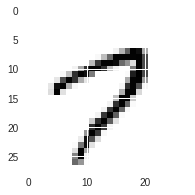

In [11]:
ind = np.random.choice(range(X.shape[0]))
plt.imshow(X[ind,...,0])

### Check the histogram of labels

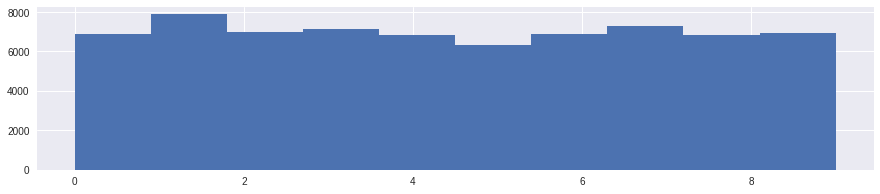

In [12]:
plt.hist(y_);

# Simple Fully Connected Model

We start with a three-layer fully-connected ANN. 

We have a categorical classification problem which means that our network should classify the image as only of the ten classes (0-9).  Because of this, we need the output activation function to be `softmax`, which approximates a probability distribution where the output layer outputs all sum to 1.

In [27]:
input_ = Input((28,28,1))

x = input_
x = Flatten()(x)
x = Dense(100,activation='relu')(x)
x = Dense(100,activation='relu')(x)


x = Dense(10, activation='softmax')(x)



model = Model(input_, x)

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 100)               78500     
_________________________________________________________________
dense_5 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_6 (Dense)              (None, 10)                1010      
Total params: 89,610
Trainable params: 89,610
Non-trainable params: 0
_________________________________________________________________


### Check the model weights

The model is initialized with random weights and can be executed before training.  Let's use Keras to examine the model weights.

#### Model layers as a list

In [28]:
model.layers

#### Model weights in the last layer

Each layer has a NxM mapping matrix of weights and M bias values.

In [29]:
model.layers[-1].weights

[<tf.Variable 'dense_6/kernel:0' shape=(100, 10) dtype=float32_ref>,
 <tf.Variable 'dense_6/bias:0' shape=(10,) dtype=float32_ref>]

#### Use `K.eval` to view weight values

In [0]:
K.eval(model.layers[-1].weights[0])

#### Plot weights

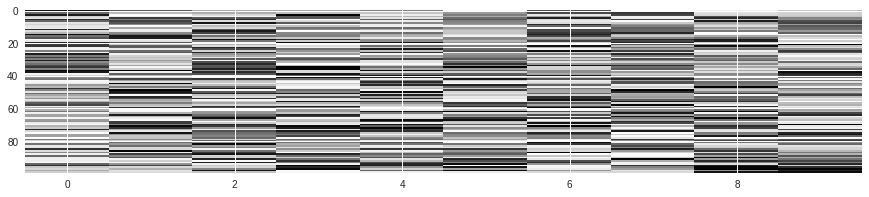

In [32]:
plt.imshow(K.eval(model.layers[-1].weights[0]),aspect='auto')

## We can also run the untrained model on the first two inputs

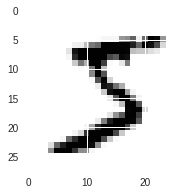

(2, 10)

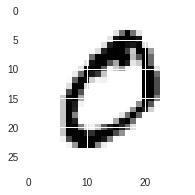

In [37]:
plt.imshow(X[0,...,0])
plt.show()
plt.imshow(X[1,...,0])
activations = model.predict(X[:2,...])

activations.shape

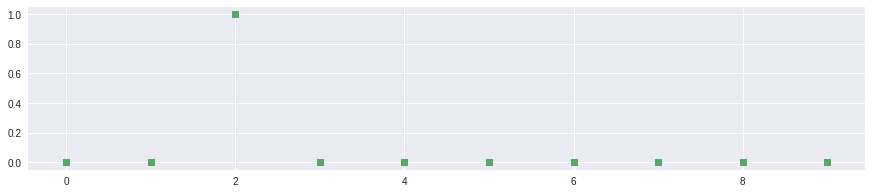

In [38]:

plt.plot(activations.T,'s')

## Train It!

In [40]:
model.compile(loss='categorical_crossentropy', optimizer=keras.optimizers.Adam(lr=.001),metrics=['accuracy'])
model.fit(X,Y, batch_size=400, epochs=10)

Epoch 1/10
70000/70000 [==============================] - 1s 20us/step - loss: 5.5436 - acc: 0.6542
Epoch 2/10
70000/70000 [==============================] - 1s 15us/step - loss: 5.5177 - acc: 0.6561
Epoch 3/10
70000/70000 [==============================] - 1s 17us/step - loss: 5.4817 - acc: 0.6586
Epoch 4/10
70000/70000 [==============================] - 1s 17us/step - loss: 5.4546 - acc: 0.6603
Epoch 5/10
70000/70000 [==============================] - 1s 17us/step - loss: 5.4329 - acc: 0.6616
Epoch 6/10
70000/70000 [==============================] - 1s 17us/step - loss: 5.4277 - acc: 0.6617
Epoch 7/10
70000/70000 [==============================] - 1s 17us/step - loss: 5.3861 - acc: 0.6646
Epoch 8/10
70000/70000 [==============================] - 1s 17us/step - loss: 5.4149 - acc: 0.6628
Epoch 9/10
50800/70000 [====================>.........] - ETA: 0s - loss: 5.3688 - acc: 0.6658

70000/70000 [==============================] - 1s 17us/step - loss: 5.3596 - acc: 0.6663
Epoch 10/10
70000/70000 [==============================] - 1s 17us/step - loss: 5.3753 - acc: 0.6651


### Check Trained model activations

70000/70000 [==============================] - 3s 48us/step


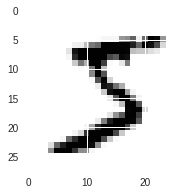

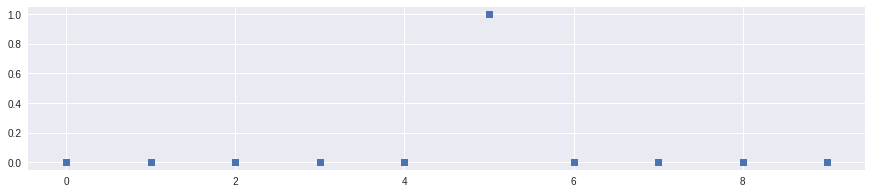

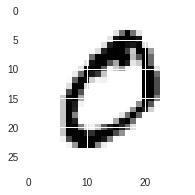

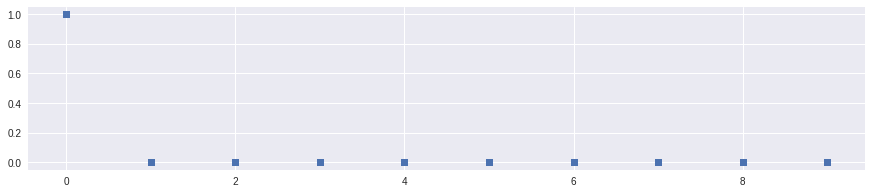

In [65]:
activations = model.predict(X, verbose=1)
plt.imshow(X[0,...,0])
plt.show()
plt.plot(activations[0,:],'s')
plt.show()
plt.imshow(X[1,...,0])
plt.show()
plt.plot(activations[1,:],'s')

Confusion matrix, without normalization


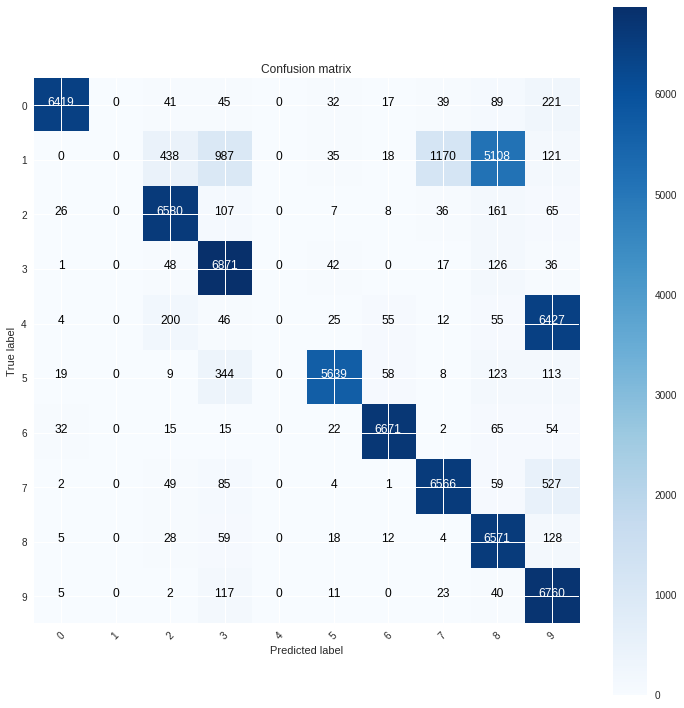

In [64]:
from sklearn.metrics import confusion_matrix
import itertools
def plot_confusion_matrix(y_test, y_pred, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.rcParams['figure.figsize'] = (10.0, 10.0)
    cm = confusion_matrix(y_test, y_pred,)
    np.set_printoptions(precision=2)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    # print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
    plt.rcParams['figure.figsize'] = (15.0, 3.0)


plot_confusion_matrix(y_, label_coder.inverse_transform(activations), label_coder.classes_);

# CNN Model

65% accurcay is impressive for such a simple model, but it isn't really usable.  In order to make the next level of improvement, we need to use convolutional layers.

In [76]:
input_ = Input((28,28,1))

x = Conv2D(32, (3,3), activation='relu')(input_)
x = Conv2D(64, (3,3), activation='relu')(x)
x = MaxPooling2D(pool_size=(2,2))(x)

x = Flatten()(x)
x = BatchNormalization()(x)
x = Dense(100,activation='relu')(x)

x = Dense(10, activation='softmax')(x)

cnn_model = Model(input_, x)
cnn_original_weights = cnn_model.get_weights()
cnn_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 24, 24, 64)        18496     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 12, 12, 64)        0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 9216)              0         
_________________________________________________________________
batch_normalization_3 (Batch (None, 9216)              36864     
_________________________________________________________________
dense_11 (Dense)             (None, 100)               921700    
__________

### Examine the convolution kernel values

Just as we did with the fully connected weight matrix, we can extract and visualize the weight matrix for the convolution kernals.

In [50]:
kerns = K.eval(cnn_model.layers[1].weights[0])
kerns.shape

(3, 3, 1, 32)

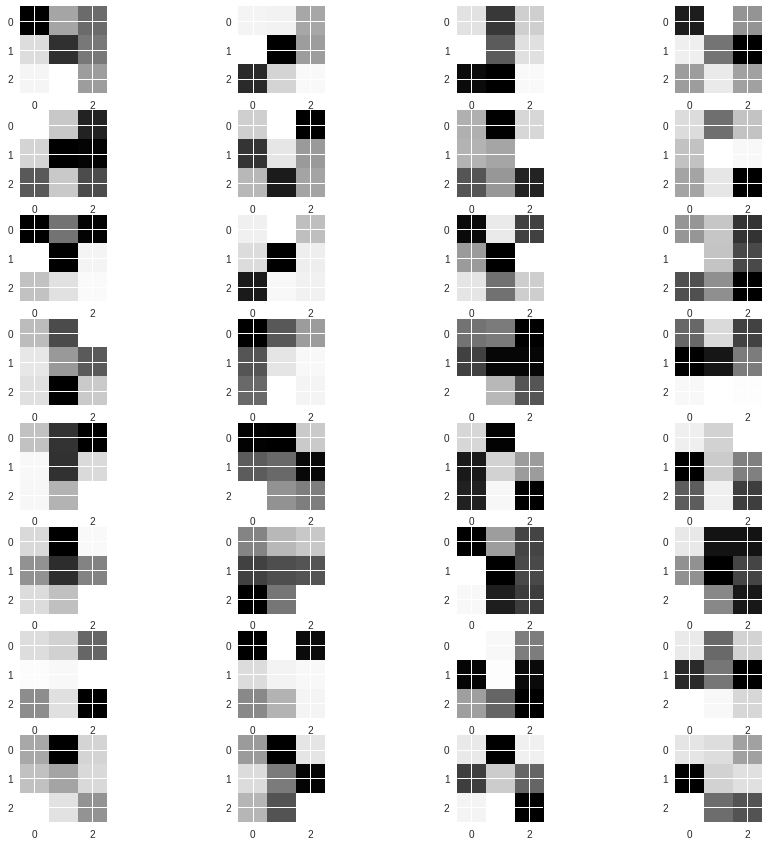

In [51]:
plt.rcParams['figure.figsize'] = (15.0, 15.0)
nrow = 8; ncol = 4;
fig, axs = plt.subplots(nrows=nrow, ncols=ncol)

k = 0
for ax in axs.reshape(-1): 
    ax.imshow(kerns[:,:,0,k])
    k += 1

### Plot Layer Flow

We can also plot the layer flow as a SVG

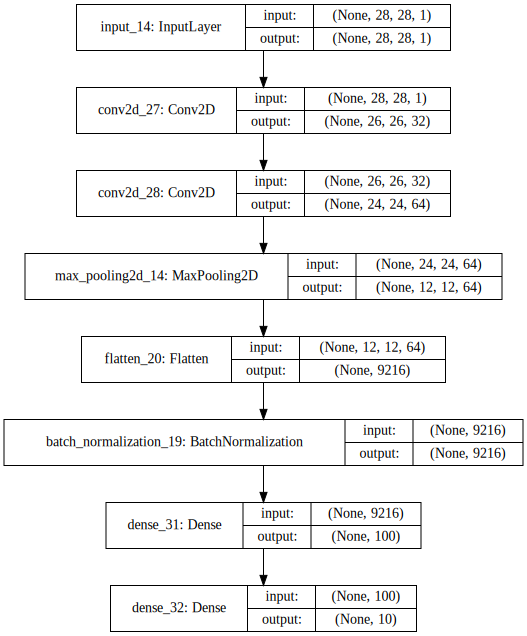

In [97]:
SVG(model_to_dot(model,True,True).create(prog='dot', format='svg'))

## Fit the CNN Model

In [0]:
cnn_model.compile(loss='categorical_crossentropy', 
                  optimizer=keras.optimizers.Adam(lr=.001),
                  metrics=['accuracy'])
cnn_model.fit(X,Y, batch_size=400, epochs=4)

### Predict Model Output


In [69]:
y_hat = cnn_model.predict(X,batch_size=400, verbose=1)

70000/70000 [==============================] - 3s 41us/step


### Plot Model Performance

Confusion matrix, without normalization


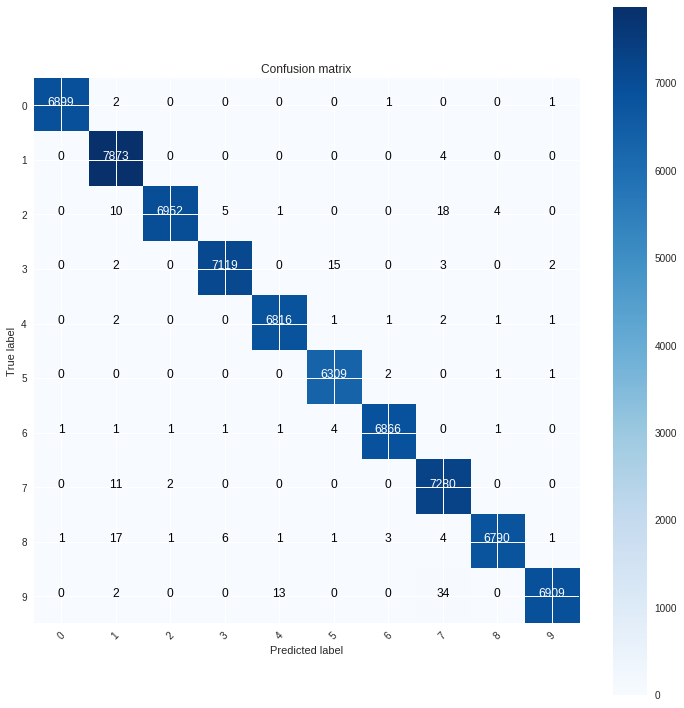

In [70]:
plot_confusion_matrix(y_, label_coder.inverse_transform(y_hat), label_coder.classes_);

# Callbacks

Keras has a convenient mechanism for taking actions in between epochs called "callbacks".  See https://keras.io/callbacks/ for details.

### Learning rate schedule
We are going to define a `LearningRateScheduler` callback, which will adjust the learning rate as we progress through epochs.

In [0]:
def lrs(epoch):
    print(f'epoch = {epoch}')
    lr = 0.001**(1+epoch/10)
    print(f'lr = {lr}')
    return lr

calls = [LearningRateScheduler(lrs)]

## Now retrain with this callback

In [78]:
cnn_model.set_weights(cnn_original_weights) # reset model
cnn_model.compile(loss='categorical_crossentropy', 
                  optimizer=keras.optimizers.Adam(lr=.001),
                  metrics=['accuracy'])
cnn_model.fit(X,Y, 
              batch_size=400, 
              epochs=4,
              validation_split=.05,
              callbacks=calls)

Train on 66500 samples, validate on 3500 samples
Epoch 1/4
epoch = 0
lr = 0.001
66500/66500 [==============================] - 9s 129us/step - loss: 0.1601 - acc: 0.9586 - val_loss: 0.0731 - val_acc: 0.9829
Epoch 2/4
epoch = 1
lr = 0.000501187233627272
66500/66500 [==============================] - 7s 109us/step - loss: 0.0263 - acc: 0.9917 - val_loss: 0.0551 - val_acc: 0.9860
Epoch 3/4
epoch = 2
lr = 0.0002511886431509581
66500/66500 [==============================] - 7s 109us/step - loss: 0.0073 - acc: 0.9979 - val_loss: 0.0221 - val_acc: 0.9943
Epoch 4/4
epoch = 3
lr = 0.0001258925411794167
14800/66500 [=====>........................] - ETA: 5s - loss: 0.0028 - acc: 0.9997

66500/66500 [==============================] - 7s 109us/step - loss: 0.0029 - acc: 0.9996 - val_loss: 0.0226 - val_acc: 0.9940


## We can also callback to tensorboard

To set this up on colab, I followed the instructions at https://www.dlology.com/blog/quick-guide-to-run-tensorboard-in-google-colab/

These instructions start tensorboard on this machine and tunnel to the tensorboard port so that we can hit the address externally.

In [87]:
LOG_DIR = './log'
! rm -rf $LOG_DIR

get_ipython().system_raw(
    'tensorboard --logdir {} --host 0.0.0.0 --port 6006 &'
    .format(LOG_DIR)
)
# Install
! npm install -g localtunnel

# Tunnel port 6006 (TensorBoard assumed running)
get_ipython().system_raw('lt --port 6006 >> url.txt 2>&1 &')

# Get url
! cat url.txt

/tools/node/bin/lt -> /tools/node/lib/node_modules/localtunnel/bin/client
+ localtunnel@1.9.0
updated 1 package in 1.058s
your url is: https://wet-deer-73.localtunnel.me
your url is: https://smooth-ape-43.localtunnel.me
your url is: https://itchy-goose-35.localtunnel.me
/tools/node/lib/node_modules/localtunnel/bin/client:65
        throw err;
        ^

Error: connection refused: localtunnel.me:43556 (check your firewall settings)
    at Socket.<anonymous> (/tools/node/lib/node_modules/localtunnel/lib/TunnelCluster.js:47:32)
    at emitOne (events.js:116:13)
    at Socket.emit (events.js:211:7)
    at emitErrorNT (internal/streams/destroy.js:64:8)
    at _combinedTickCallback (internal/process/next_tick.js:138:11)
    at process._tickCallback (internal/process/next_tick.js:180:9)
your url is: https://curly-sheep-62.localtunnel.me


In [88]:
from keras.callbacks import TensorBoard
cnn_model.set_weights(cnn_original_weights) # reset model

cnn_model.compile(loss='categorical_crossentropy', 
                  optimizer=keras.optimizers.Adam(lr=.001),
                  metrics=['accuracy'])


tbCallBack = TensorBoard(log_dir='./log/cnn_model/', histogram_freq=1,
                         write_graph=True,
                         write_grads=True,
                         batch_size=400,
                         write_images=True)

cnn_model.fit(X,Y, 
              batch_size=400, 
              epochs=4,
              validation_split=.05,
              callbacks=[tbCallBack, LearningRateScheduler(lrs)])

Train on 66500 samples, validate on 3500 samples
Epoch 1/4
epoch = 0
lr = 0.001
66500/66500 [==============================] - 10s 155us/step - loss: 0.1560 - acc: 0.9589 - val_loss: 0.0824 - val_acc: 0.9754


InvalidArgumentError: ignored